In [90]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import PIL
import pandas as pd
import torchvision 
import torch 
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
from time import time
import PIL
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
from torch.utils.data.dataset import Dataset
from torchvision import transforms

In [91]:
data_count = 50000

y_data = pd.read_csv("list_landmarks_align_celeba.csv")
y_data = np.array(y_data)
landmarks = y_data[:data_count,1:]
image_names = y_data[:data_count,:1]
x_data = []

i=0

for idx, image_name in enumerate(image_names):
    
    image_path = "C:/Users/Asus/Desktop/landmark detection2/img_align_celeba/img_align_celeba/" + image_name[0]
    im = Image.open(image_path)
    im = np.array(im)
    img_as_img = Image.fromarray(im)
    img_as_img = img_as_img.convert('L')
    im = np.array(img_as_img)
    x_data.append(im)
   

x_data = np.array(x_data)
print(x_data.shape)
print(landmarks.shape)

(50000, 218, 178)
(50000, 10)


### Scaling

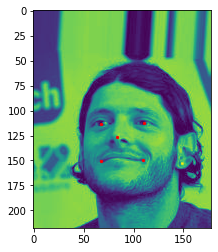

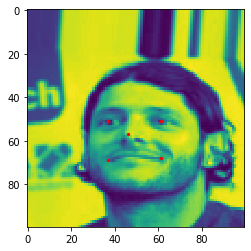

In [92]:
data_id = 75

x = []
y = []
for idx, coordinate in enumerate(landmarks[data_id]):
    if idx % 2 == 0:
        x.append(coordinate)
    else:
        y.append(coordinate)

        
img_as_np = x_data[data_id]
img_as_img = Image.fromarray(img_as_np)
img_as_img = img_as_img.convert('L')
plt.imshow(img_as_img)
plt.scatter(x,y, c = "r", s=5)
plt.figure()

#Scaling labels for 100x100px
landmarks = list(landmarks)
scaled_landmarks = []
new_line = []
for line in landmarks:

    new_line = []
    for idx, pix in enumerate(line):

        if idx % 2 == 0:
            new_line.append(int(pix/(178/100)))
        else:
            new_line.append(int(pix/(218/100)))
   
    scaled_landmarks.append(new_line)

    
x = []
y = []
for idx, coordinate in enumerate(scaled_landmarks[data_id]):
  
    if idx % 2 == 0:
        x.append(coordinate)
    else:
        y.append(coordinate)

scaled_landmarks = np.array(scaled_landmarks)   
        
train_transforms = transforms.Compose([
        transforms.Grayscale(num_output_channels=1), 
        transforms.Resize((100,100)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485],
                                         std=[0.229])
        ])

im = train_transforms(img_as_img)
im = im.view(1,100,100)
z = im * torch.tensor([0.229])
z = z + torch.tensor([0.485])
img = transforms.ToPILImage(mode='L')(z)
plt.imshow(img)
plt.scatter(x,y, c="r", s=5)

### Parameters

In [93]:
lr=0.001
epoch_count = 100
train_ratio = 0.85
train_batch_size = 120
validation_batch_size= 120

### Loading

#x: numpy -> pil -> torch    y: numpy -> torch

In [94]:
class CustomDatasetFromCSV(Dataset):
    def __init__(self, x, y, img_size, transforms=None):

        self.data = x
        self.labels = y
        self.transforms = transforms
        self.img_size = img_size

    def __getitem__(self, index):
        single_image_label = self.labels[index]
        single_image_label = np.float32(single_image_label)
        single_image_label = torch.from_numpy(single_image_label)
        img_as_np = self.data[index]
	# Convert image from numpy array to PIL image, mode 'L' is for grayscale
        img_as_img = Image.fromarray(img_as_np)
        img_as_img = img_as_img.convert('L')
        # Transform image to tensor
        if self.transforms is not None:
            img_as_tensor = self.transforms(img_as_img)
        # Return image and the label
        return (img_as_tensor.view(1, self.img_size, self.img_size), single_image_label)

    def __len__(self):
        return self.data.shape[0]
        
train_transforms = transforms.Compose([
transforms.Grayscale(num_output_channels=1), 
transforms.Resize((100,100)),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485],
                                 std=[0.229])
])

dataset = CustomDatasetFromCSV(x_data, scaled_landmarks, 100, train_transforms)

dataset_size = data_count
train_set_size = int(dataset_size * train_ratio)
validation_set_size = dataset_size - train_set_size 

    
print("Training set size:", train_set_size)
print("Validation set size:", validation_set_size)

train_set, validation_set = torch.utils.data.random_split(dataset, [train_set_size, validation_set_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size = train_batch_size, shuffle=True, drop_last=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size = validation_batch_size, shuffle=True, drop_last=True)
    

train_loader = [batch for batch in train_loader]
train_batch_count = len(train_loader)
print("Traning Set Batch Count:",train_batch_count)
print("Training Set Batch Size:",train_batch_size)
    
validation_loader = [batch for batch in validation_loader]
validation_batch_count = len(validation_loader)
print("Validation Set Batch Count:",validation_batch_count)
print("Validation Set Batch Size:",validation_batch_size)

Training set size: 42500
Validation set size: 7500
Traning Set Batch Count: 354
Training Set Batch Size: 120
Validation Set Batch Count: 62
Validation Set Batch Size: 120


In [14]:
train_loader[0][0].shape

torch.Size([200, 1, 100, 100])

### Model

In [95]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
            
        self.channel = 8
        self.conv1 = torch.nn.Conv2d(in_channels = 1, out_channels = self.channel, kernel_size = 7) 
        #torch.nn.init.xavier_uniform_(self.conv1.weight)
        self.conv2 = torch.nn.Conv2d(in_channels = self.channel, out_channels = self.channel+2, kernel_size = 5)
        #torch.nn.init.xavier_uniform_(self.conv2.weight)
        self.conv3 = torch.nn.Conv2d(in_channels = self.channel+2, out_channels = self.channel+7, kernel_size = 3)
        #torch.nn.init.xavier_uniform_(self.conv3.weight)
        self.conv4 = torch.nn.Conv2d(in_channels = self.channel+7, out_channels = self.channel+9, kernel_size = 1)
        #torch.nn.init.xavier_uniform_(self.conv4.weight)

        self.bn1 = nn.BatchNorm1d(num_features=150)
            
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.pool = nn.MaxPool2d(2, 2)

        self.beta1 = nn.Linear((self.channel+9)*4*4, 150)
        #torch.nn.init.xavier_uniform_(self.beta1.weight)
        self.beta2 = nn.Linear(150, 150)
        #torch.nn.init.xavier_uniform_(self.beta2.weight)
        self.beta3 = nn.Linear(150, 150)
        #torch.nn.init.xavier_uniform_(self.beta3.weight)
        self.beta4 = nn.Linear(150, 10)
        #torch.nn.init.xavier_uniform_(self.beta4.weight)
            
            

    def forward(self, X):

        y=self.conv1(X) 
        y=torch.nn.functional.relu(y)
        y=self.pool(y) 
        y=self.conv2(y) 
        y=torch.nn.functional.relu(y)
        y=self.pool(y) 
        y=self.conv3(y) 
        y=torch.nn.functional.relu(y)
        y=self.pool(y) 
        y=self.conv4(y) 
        y=torch.nn.functional.relu(y)
        y=self.pool(y) 
        #y=self.dropout1(y)

        #y = y.view(X.shape[0], self.channel*25*25)
        #print(y.shape)
        y = y.view(X.shape[0], (self.channel+9)*4*4)
            
        y=self.beta1(y)
        #y=self.dropout1(y)
        y=torch.nn.functional.relu(y)
        y=self.beta2(y)
        #y=self.dropout2(y)
        y=torch.nn.functional.relu(y)
        y=self.beta2(y)
        y=torch.nn.functional.relu(y)
        y=self.beta3(y)
        y=self.bn1(y) 
        y=torch.nn.functional.relu(y)
        y=self.beta4(y)
          
           
        return y
        

In [97]:
model = Net()
criterion = torch.nn.MSELoss()
#criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    
training_loss_list = []
validation_loss_list = []


t = time()

for epoch in range(epoch_count):
        
    training_loss = 0
        
    for batch_id in range(len(train_loader)):
        X,y = train_loader[batch_id]

        model.train()
        optimizer.zero_grad()
        cikti = model(X)
        y = y.float()
 
        loss = criterion(cikti, y)
        loss.backward()
        optimizer.step()
        
        
        with torch.no_grad():
            model.eval()
            cikti = model(X)
            loss = criterion(cikti, y)
            training_loss += loss.item()
                
    training_loss = training_loss/train_batch_count
    training_loss_list.append(training_loss)  

    print("Epoch {} | Training Loss: {} ".format(epoch,training_loss))
    print("Geçen süre: {} mins".format(round((time() - t) / 60, 2)))
    #****************************************************************************     
        
        
    validation_loss = 0
                  
    for batch_id in range(len(validation_loader)): 
        X,y = validation_loader[batch_id]
        with torch.no_grad():

            model.eval()
            cikti = model(X)
            y = y.float()
            loss = criterion(cikti, y)
            validation_loss += loss.item() 

         
    validation_loss = validation_loss/validation_batch_count
    validation_loss_list.append(validation_loss)  

    print("Epoch {} | Validation Loss: {}".format(epoch,validation_loss)) 
    print("Geçen süre: {} mins".format(round((time() - t) / 60, 2)))
    #****************************************************************************   
    
    #ModelSaving
    checkpoint = {'state_dict': model.state_dict(),'optimizer' :optimizer.state_dict()}
    torch.save(checkpoint, '{} Checkpoint.pth'.format(epoch))
    print("Model kaydedildi.")
    
    print("********************************************************")
        
        


Epoch 0 | Training Loss: 1674.1659602795617 
Geçen süre: 5.59 mins
Epoch 0 | Validation Loss: 239.6061253701487
Geçen süre: 5.92 mins
Model kaydedildi.
********************************************************
Epoch 1 | Training Loss: 46.3362755027868 
Geçen süre: 11.85 mins
Epoch 1 | Validation Loss: 4.028930479480374
Geçen süre: 12.18 mins
Model kaydedildi.
********************************************************
Epoch 2 | Training Loss: 3.492212560217259 
Geçen süre: 18.2 mins
Epoch 2 | Validation Loss: 3.2591902671321744
Geçen süre: 18.53 mins
Model kaydedildi.
********************************************************
Epoch 3 | Training Loss: 3.3812149385947965 
Geçen süre: 24.63 mins
Epoch 3 | Validation Loss: 3.758102551583321
Geçen süre: 24.96 mins
Model kaydedildi.
********************************************************
Epoch 4 | Training Loss: 3.25281480544031 
Geçen süre: 31.09 mins
Epoch 4 | Validation Loss: 3.546410091461674
Geçen süre: 31.42 mins
Model kaydedildi.
*********

KeyboardInterrupt: 

### Test

[39.0982551574707, 50.98930358886719, 60.832950592041016, 51.14260482788086, 49.580848693847656, 62.232120513916016, 40.18253707885742, 70.19090270996094, 59.5692253112793, 70.33899688720703]


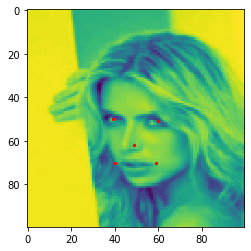

In [123]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import PIL
import pandas as pd
import torchvision 
import torch 
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
from time import time
import PIL
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
from torch.utils.data.dataset import Dataset
from torchvision import transforms

class Net(nn.Module):
    def __init__(self):
        super().__init__()
            
        self.channel = 8
        self.conv1 = torch.nn.Conv2d(in_channels = 1, out_channels = self.channel, kernel_size = 7) 
        #torch.nn.init.xavier_uniform_(self.conv1.weight)
        self.conv2 = torch.nn.Conv2d(in_channels = self.channel, out_channels = self.channel+2, kernel_size = 5)
        #torch.nn.init.xavier_uniform_(self.conv2.weight)
        self.conv3 = torch.nn.Conv2d(in_channels = self.channel+2, out_channels = self.channel+7, kernel_size = 3)
        #torch.nn.init.xavier_uniform_(self.conv3.weight)
        self.conv4 = torch.nn.Conv2d(in_channels = self.channel+7, out_channels = self.channel+9, kernel_size = 1)
        #torch.nn.init.xavier_uniform_(self.conv4.weight)

        self.bn1 = nn.BatchNorm1d(num_features=150)
            
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.pool = nn.MaxPool2d(2, 2)

        self.beta1 = nn.Linear((self.channel+9)*4*4, 150)
        #torch.nn.init.xavier_uniform_(self.beta1.weight)
        self.beta2 = nn.Linear(150, 150)
        #torch.nn.init.xavier_uniform_(self.beta2.weight)
        self.beta3 = nn.Linear(150, 150)
        #torch.nn.init.xavier_uniform_(self.beta3.weight)
        self.beta4 = nn.Linear(150, 10)
        #torch.nn.init.xavier_uniform_(self.beta4.weight)
            
            

    def forward(self, X):

        y=self.conv1(X) 
        y=torch.nn.functional.relu(y)
        y=self.pool(y) 
        y=self.conv2(y) 
        y=torch.nn.functional.relu(y)
        y=self.pool(y) 
        y=self.conv3(y) 
        y=torch.nn.functional.relu(y)
        y=self.pool(y) 
        y=self.conv4(y) 
        y=torch.nn.functional.relu(y)
        y=self.pool(y) 
        #y=self.dropout1(y)

        #y = y.view(X.shape[0], self.channel*25*25)
        #print(y.shape)
        y = y.view(X.shape[0], (self.channel+9)*4*4)
            
        y=self.beta1(y)
        #y=self.dropout1(y)
        y=torch.nn.functional.relu(y)
        y=self.beta2(y)
        #y=self.dropout2(y)
        y=torch.nn.functional.relu(y)
        y=self.beta2(y)
        y=torch.nn.functional.relu(y)
        y=self.beta3(y)
        y=self.bn1(y) 
        y=torch.nn.functional.relu(y)
        y=self.beta4(y)
          
           
        return y
        
    
    
def deploy(filepath, test_im):
    
    train_transforms = transforms.Compose([
        transforms.Grayscale(num_output_channels=1), 
        transforms.Resize((100,100)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485],
                                         std=[0.229])
        ])


    def load_checkpoint(filepath, Net):
        checkpoint = torch.load(filepath)
        model = Net
        model.load_state_dict(checkpoint['state_dict'])
        for parameter in model.parameters():
            parameter.requires_grad = False

        return model.eval()



    model = load_checkpoint(filepath, Net())

    """test_im = Image.open(image_path)
    test_im = np.array(test_im)
    test_im = Image.fromarray(test_im)
    test_im = test_im.convert('L')
    #plt.imshow(test_im)
    test_im = train_transforms(test_im)"""
    test_im = test_im.unsqueeze(0) #dimension expansion
    

    
    with torch.no_grad():
        model.eval()
        out = model(test_im)    
        out = out.tolist()[0]
     
    x = []
    y = []
    for idx, coordinate in enumerate(out):

        if idx % 2 == 0:
            x.append(int(coordinate))
        else:
            y.append(int(coordinate))
            
            

    print(out)

    
    test_im = test_im.view(1,100,100)
    z = test_im * torch.tensor([0.229])
    z = z + torch.tensor([0.485])
    img = transforms.ToPILImage(mode='L')(z)
    plt.imshow(img)
    plt.scatter(x,y, c="r", s=5)
    
    return model
    
    
model = deploy("4 Checkpoint.pth", validation_loader[0][0][4])